In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader
from torch.utils.data import Dataset

from torchvision import transforms

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


## Configuration

In [2]:
BATCH_SIZE = 16

## Data (SIN)

In [3]:
class SinDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.scaler = MinMaxScaler()
        self.data = self._create_data()
        
    def _create_data(self, size=1024):
        data = list()
        for i in range(size):
            x = np.linspace(0, 2*np.pi, 64).reshape(-1, 1)
            x = np.sin(x)
            x = self.scaler.fit_transform(x)
            data.append(x)
        
        data = np.array(data)
        return data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = torch.FloatTensor(sample)
        return sample
        

sin_dataset = SinDataset()  
dataloader_args = dict(shuffle=False, batch_size=10, num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(sin_dataset, **dataloader_args)
SEQ_SIZE = train_loader.dataset.data.shape[1]

print('data:', train_loader.dataset.data.shape)
print('SEQ SIZE:', SEQ_SIZE)

data: (1024, 64, 1)
SEQ SIZE: 64


No handles with labels found to put in legend.


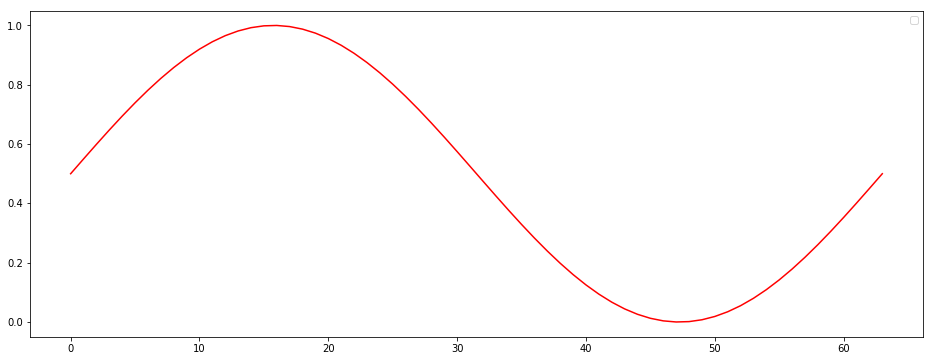

In [22]:
def display_data(data, **kargs):
    N = data.shape[0]
    idx = np.random.randint(N)
    plot(data[idx], **kargs)
    legend()

display_data(train_loader.dataset.data, color='red')

## Model Discriminator

### Discriminator

* $ x_i \sim P_{\rm data} $ (즉 true data distribution) 에서 왔다면 1
* $ x_i = G(z) $ 이때 $ z \sim p_{\rm generator} $ (generators' distribution)에서 왔다면 0

즉 Discriminator는 "이 사진이 진짜냐? (가짜가 아니고)" 라고 질문하는 것

In [5]:
np.random.seed(0)
torch.manual_seed(0)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(64, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 32)
        self.linear4 = nn.Linear(32, 1)
                
    def forward(self, x, _return_activations=False):
        b, s, h = x.size()
        h = x.view((-1, s*h))
        
        h1 = F.leaky_relu(self.linear1(h), negative_slope=0.2)
        h2 = F.leaky_relu(self.linear2(h1), negative_slope=0.2)
        h3 = F.leaky_relu(self.linear3(h2), negative_slope=0.2)
        
        out = F.sigmoid(self.linear4(h3))
        if _return_activations:
            return out, [out]
        return out
    
    def feature_mapping(self, real, fake):
        _, real_fs = self.forward(real, _return_activations=True)
        _, fake_fs = self.forward(fake, _return_activations=True)
        real = real_fs
        
        diffs = []
        for real, fake in zip(real_fs, fake_fs):
            diff = torch.mean(torch.pow(real - fake, 2))
            diffs.append(diff)
        
        output = torch.sum(torch.stack(diffs))
        return output

D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.0001)

# fake_distributions = Variable(torch.randn((7, 100)).cuda())
# D(G(fake_distributions))

Discriminator(
  (linear1): Linear(in_features=64, out_features=128)
  (linear2): Linear(in_features=128, out_features=64)
  (linear3): Linear(in_features=64, out_features=32)
  (linear4): Linear(in_features=32, out_features=1)
)


### Generator

`nn.rnn`

원래는 다음과 같다. 

- input: (seq_len, batch, input_size)
- output
  - output: (seq_len, batch, hidden_size * num_directions)
  - hidden: (num_layers * num_directions, batch, hidden_size)
  
batch_first를 True하게 되면은 다음과 같다. 
- input: (batch, seq_len, input_size)
- output
  - output: (batch, seq_len, hidden_size * num_directions)
  - hidden: (num_layers * num_directions, batch, hidden_size) <- 바뀌지 않는다.


In [6]:
np.random.seed(0)
torch.manual_seed(0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.dense1 = nn.Linear(100, 256)
        self.dense2 = nn.Linear(256, SEQ_SIZE)
        self.rnn = nn.LSTM(1, hidden_size=32, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(64, 1)
        
    def forward(self, x):
        h = F.leaky_relu(self.dense1(x), negative_slope=0.2)
        h = F.leaky_relu(self.dense2(h), negative_slope=0.2)
        h = h.view(-1, h.size(-1), 1)
        h, (hidden1, hidden2) = self.rnn(h)
        h = self.fc(h)
        return h

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.0001)

fake_distributions = Variable(torch.randn((7, 100)).cuda())
G(fake_distributions).size()

Generator(
  (dense1): Linear(in_features=100, out_features=256)
  (dense2): Linear(in_features=256, out_features=64)
  (rnn): LSTM(1, 32, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1)
)


torch.Size([7, 64, 1])

## Train

* $ 1 $ : real images
* $ 0 $ : fake images

In [7]:
N_EPOCH = 300
real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()

In [8]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
for epoch in range(N_EPOCH):
    for step, x in enumerate(train_loader):
        x = Variable(x.cuda())
        _batch_size = x.size(0)
            
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(x)
        d_real_loss = loss_f(y_real_pred, real_y[:_batch_size])
        
        
        # Calculate the loss with fake images
        noise = Variable(torch.randn((_batch_size, 100)).cuda())
        fake_x = G(noise).detach()
        y_fake_pred = D(fake_x)
        d_fake_loss = loss_f(y_fake_pred, fake_y[:_batch_size])
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        noise = Variable(torch.randn((_batch_size, 100)).cuda())
        g_loss = D.feature_mapping(x, G(noise))
        g_loss.backward()
        g_optimizer.step()
        
        ###############################################
        # Visualization
        ###############################################
        if step%5 == 0:
            d_real_losses.append(d_real_loss.data[0])
            d_fake_losses.append(d_fake_loss.data[0])
            d_losses.append(d_loss.data[0])
            g_losses.append(g_loss.data.cpu().numpy()[0])

            divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 50 == 0:
            print(f'\r[{epoch+1}/{N_EPOCH}]',
                  # '{:.3}'.format(torch.mean(params[0]).data[0]),
                  'divergence: {:<8.3}'.format(np.mean(divergences[-100:])),
                  'D: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'D_real: {:<8.3}'.format(np.mean(d_real_losses[-100:])),
                  'D_fake: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'G:{:<8.3}'.format(np.mean(g_losses[-100:])), end='')
            
    print()

[1/300] divergence: 0.529    D: 0.744    D_real: 0.528    D_fake: 0.744    G:0.0081  
[2/300] divergence: 0.569    D: 0.732    D_real: 0.379    D_fake: 0.732    G:0.0471  
[3/300] divergence: 0.552    D: 0.799    D_real: 0.4      D_fake: 0.799    G:0.034   
[4/300] divergence: 0.547    D: 0.76     D_real: 0.458    D_fake: 0.76     G:0.027   
[5/300] divergence: 0.543    D: 0.729    D_real: 0.509    D_fake: 0.729    G:0.0243  
[6/300] divergence: 0.546    D: 0.657    D_real: 0.596    D_fake: 0.657    G:0.0245  
[7/300] divergence: 0.531    D: 0.613    D_real: 0.706    D_fake: 0.613    G:0.00821 
[8/300] divergence: 0.535    D: 0.549    D_real: 0.751    D_fake: 0.549    G:0.00868 
[9/300] divergence: 0.53     D: 0.566    D_real: 0.749    D_fake: 0.566    G:0.00753 
[10/300] divergence: 0.532    D: 0.587    D_real: 0.705    D_fake: 0.587    G:0.00702 
[11/300] divergence: 0.522    D: 0.635    D_real: 0.673    D_fake: 0.635    G:0.00337 
[12/300] divergence: 0.518    D: 0.662    D_real: 0.

[95/300] divergence: 0.529    D: 0.665    D_real: 0.631    D_fake: 0.665    G:0.016   
[96/300] divergence: 0.526    D: 0.659    D_real: 0.65     D_fake: 0.659    G:0.0153  
[97/300] divergence: 0.525    D: 0.647    D_real: 0.665    D_fake: 0.647    G:0.0145  
[98/300] divergence: 0.519    D: 0.65     D_real: 0.683    D_fake: 0.65     G:0.0124  
[99/300] divergence: 0.517    D: 0.658    D_real: 0.686    D_fake: 0.658    G:0.0113  
[100/300] divergence: 0.516    D: 0.673    D_real: 0.671    D_fake: 0.673    G:0.00891 
[101/300] divergence: 0.516    D: 0.682    D_real: 0.664    D_fake: 0.682    G:0.00962 
[102/300] divergence: 0.522    D: 0.683    D_real: 0.643    D_fake: 0.683    G:0.0126  
[103/300] divergence: 0.522    D: 0.68     D_real: 0.642    D_fake: 0.68     G:0.0125  
[104/300] divergence: 0.522    D: 0.685    D_real: 0.635    D_fake: 0.685    G:0.0136  
[105/300] divergence: 0.517    D: 0.692    D_real: 0.649    D_fake: 0.692    G:0.012   
[106/300] divergence: 0.52     D: 0.6

[188/300] divergence: 0.505    D: 0.689    D_real: 0.696    D_fake: 0.689    G:0.00441 
[189/300] divergence: 0.505    D: 0.682    D_real: 0.698    D_fake: 0.682    G:0.00388 
[190/300] divergence: 0.507    D: 0.677    D_real: 0.697    D_fake: 0.677    G:0.00627 
[191/300] divergence: 0.507    D: 0.671    D_real: 0.707    D_fake: 0.671    G:0.00612 
[192/300] divergence: 0.502    D: 0.671    D_real: 0.72     D_fake: 0.671    G:0.00466 
[193/300] divergence: 0.501    D: 0.672    D_real: 0.725    D_fake: 0.672    G:0.00564 
[194/300] divergence: 0.5      D: 0.679    D_real: 0.721    D_fake: 0.679    G:0.00587 
[195/300] divergence: 0.498    D: 0.689    D_real: 0.716    D_fake: 0.689    G:0.00478 
[196/300] divergence: 0.5      D: 0.712    D_real: 0.689    D_fake: 0.712    G:0.00498 
[197/300] divergence: 0.501    D: 0.732    D_real: 0.665    D_fake: 0.732    G:0.00576 
[198/300] divergence: 0.505    D: 0.736    D_real: 0.647    D_fake: 0.736    G:0.00654 
[199/300] divergence: 0.504    D

[281/300] divergence: 0.509    D: 0.708    D_real: 0.663    D_fake: 0.708    G:0.0087  
[282/300] divergence: 0.505    D: 0.71     D_real: 0.675    D_fake: 0.71     G:0.00584 
[283/300] divergence: 0.507    D: 0.699    D_real: 0.682    D_fake: 0.699    G:0.00776 
[284/300] divergence: 0.507    D: 0.679    D_real: 0.708    D_fake: 0.679    G:0.00761 
[285/300] divergence: 0.503    D: 0.658    D_real: 0.736    D_fake: 0.658    G:0.0059  
[286/300] divergence: 0.505    D: 0.65     D_real: 0.737    D_fake: 0.65     G:0.00648 
[287/300] divergence: 0.505    D: 0.662    D_real: 0.727    D_fake: 0.662    G:0.00747 
[288/300] divergence: 0.503    D: 0.684    D_real: 0.703    D_fake: 0.684    G:0.00576 
[289/300] divergence: 0.502    D: 0.708    D_real: 0.683    D_fake: 0.708    G:0.00582 
[290/300] divergence: 0.503    D: 0.733    D_real: 0.664    D_fake: 0.733    G:0.00867 
[291/300] divergence: 0.502    D: 0.753    D_real: 0.652    D_fake: 0.753    G:0.00899 
[292/300] divergence: 0.502    D

## Loss Visualization

In [9]:
def smooth(x,window_len=100,window='hanning'):
    x = np.array(x)
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

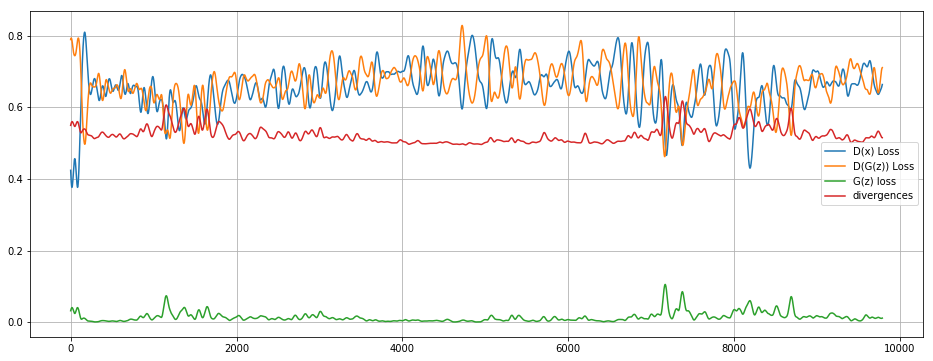

In [28]:
figsize(16, 6)
plot(smooth(d_real_losses), label='D(x) Loss')
plot(smooth(d_fake_losses), label='D(G(z)) Loss')
plot(smooth(g_losses), label='G(z) loss')
plot(smooth(divergences), label='divergences')

grid()
legend()

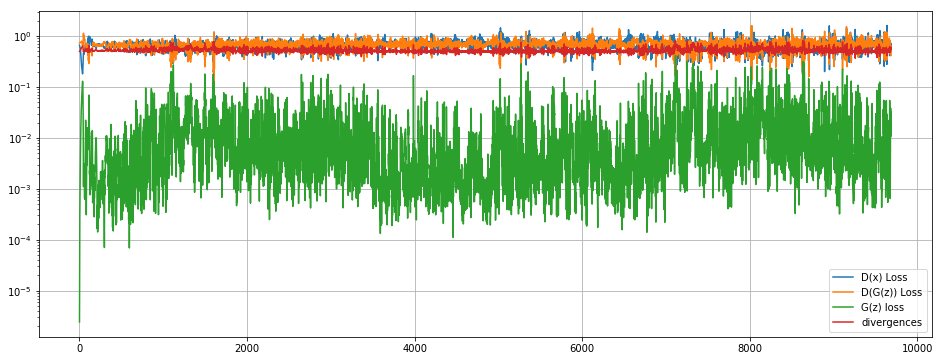

In [29]:
plot(d_real_losses, label='D(x) Loss')
plot(d_fake_losses, label='D(G(z)) Loss')
plot(g_losses, label='G(z) loss')
plot(divergences, label='divergences')

yscale('log')
grid()
legend()

# Evaluate

## Evaluate Generator

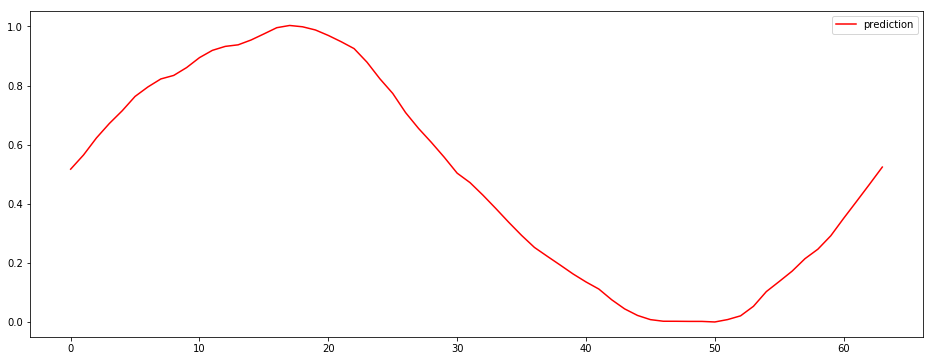

In [33]:
fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
generated_sins = G(fake_distributions).data.cpu().numpy()

display_data(generated_sins, color='red', label='prediction')
# display_data(train_loader.dataset.data, color='#333333', label='true observation')

## Evaluate Discriminator

In [13]:
n_test = train_loader.dataset.test_data.size()[0]
y_test_real_labels = np.ones((n_test, 1))
y_test_fake_labels = np.zeros((n_test, 1))

# Predict Real Images
test_data = Variable(train_loader.dataset.test_data.cuda().type_as(torch.cuda.FloatTensor()))
y_test_real_pred = D(test_data)


# Predict Fake Images
fake_distributions = Variable(torch.randn((n_test, 100)).cuda())
fake_images = G(fake_distributions).detach()
y_test_fake_pred = D(fake_images)

# Evaluate
y_test_real_pred = torch.round(y_test_real_pred).data.cpu().numpy()
y_test_fake_pred = torch.round(y_test_fake_pred).data.cpu().numpy()

print('Discriminator Real Image Accuracy:', accuracy_score(y_test_real_labels, y_test_real_pred))
print('Discriminator Fake Image Accuracy:', accuracy_score(y_test_fake_labels, y_test_fake_pred))

AttributeError: 'SinDataset' object has no attribute 'test_data'